In [ ]:
from typing import Optional

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

In [ ]:
def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
  r"""Apply positional encoding to the input.

  Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    num_encoding_functions (optional, int): Number of encoding functions used to
        compute a positional encoding (default: 6).
    include_input (optional, bool): Whether or not to include the input in the
        computed positional encoding (default: True).
    log_sampling (optional, bool): Sample logarithmically in frequency space, as
        opposed to linearly (default: True).

  Returns:
    (torch.Tensor): Positional encoding of the input tensor.
  """
  # TESTED
  # Trivially, the input tensor is added to the positional encoding.
  encoding = [tensor] if include_input else []
  # Now, encode the input using a set of high-frequency functions and append the
  # resulting values to the encoding.
  frequency_bands = None
  if log_sampling:
      frequency_bands = 2.0 ** torch.linspace(
          0.0,
          num_encoding_functions - 1,
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )
  else:
      frequency_bands = torch.linspace(
          2.0 ** 0.0,
          2.0 ** (num_encoding_functions - 1),
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )

  for freq in frequency_bands:
      for func in [torch.sin, torch.cos]:
          encoding.append(func(tensor * freq))

  # Special case, for no positional encoding
  if len(encoding) == 1:
      return encoding[0]
  else:
      return torch.cat(encoding, dim=-1)


In [ ]:
class VeryTinyNerfModel(torch.nn.Module):
  r"""Define a "very tiny" NeRF model comprising three fully connected layers.
  """

  def __init__(self, filter_size=256, num_encoding_functions=6, num_hidden_layers=8):
    super(VeryTinyNerfModel, self).__init__()
    n_input_dims = 3
    # Input layer (default: 39 -> 256)
    input_size = n_input_dims + n_input_dims * 2 * num_encoding_functions
    self.input_layer = torch.nn.Linear(
        input_size, filter_size)
    # Hidden layers
    self.hidden_layers = []
    for i in range(num_hidden_layers):
      # if i == 2:
        # self.hidden_layers.append(torch.nn.Linear(filter_size + input_size, filter_size))
      # else:
        self.hidden_layers.append(torch.nn.Linear(filter_size, filter_size))
    # Output layer
    self.output_layer = torch.nn.Linear(filter_size, 3)
    # Short hand for torch.nn.functional.relu
    self.relu = torch.nn.functional.relu

  def forward(self, x):
    # input_x = x
    x = self.relu(self.input_layer(x))
    for i, hl in enumerate(self.hidden_layers):
      # if i == 2:
        # skip connection
        # x = torch.cat((x, input_x), 1)
      x = self.relu(hl(x))
    # Sigmoid on the output layer b/c RGB is 0-1
    x = torch.sigmoid(self.output_layer(x))
    return x

In [ ]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  r"""
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunksize`.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
cap = cv2.VideoCapture("../datasets/00003.mp4")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)

def get_frame(idx):
  r""" Get the RGB tensor of a specific frame in the video.
  """
  cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
  success, img = cap.read()
  if not success:
    print("Failed to load frame at index " + str(idx))
  return torch.from_numpy(np.float32(img) / 255)


In [ ]:
def xs_and_ys(width, height, frame_ind):
    r""" Construct (x, y, f) tuples.
    """
    res = []
    for y in range(height):
        for x in range(width):
            res.append([y / height, x / width, frame_ind])
    return torch.from_numpy(np.array(res, dtype=np.float32))

In [13]:
def one_iter_npc(width, height, model, frame_ind, encoding_fn, get_minibatches_fn, chunksize):

  pts = xs_and_ys(width, height, frame_ind)

  encoded_pts = encoding_fn(pts)
  batches = get_minibatches_fn(encoded_pts, chunksize=chunksize)

  predictions = []
  for batch in batches:
    predictions.append(model(batch))
  
  rgb_flat = torch.cat(predictions, dim=0)
  rgb = torch.reshape(rgb_flat, [height, width, 3])
  return rgb

In [ ]:
def output_video(total_frames: int, fps, width: int, height: int, encode, get_minibatches, chunksize):
  r"""Build the final video from the trained model."""
  out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
  for f in range(total_frames):
      rgb_predicted = one_iter_npc(width, height, model,
                                   f, encode,
                                   get_minibatches, chunksize)

      rgb_out = cv2.normalize(src=rgb_predicted.detach().cpu().numpy(), dst=None, alpha=0, beta=255,
              norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
      # rgb_numpy = rgb_predicted.detach().numpy() * 255
      # rgb_numpy = rgb_numpy.astype('uint8')
      out.write(rgb_out)
  
  out.release()

In [ ]:
"""
Parameters for NPC training
"""

num_hidden_layers = 4
filter_size = 256
# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 12

# Specify encoding function.
def encode(x): return positional_encoding(
    x, num_encoding_functions=num_encoding_functions, include_input=True, log_sampling=True)

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
# Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.
chunksize = 16384 * 16

# Optimizer parameters
lr = 5e-3
num_iters = 2_000

# Misc parameters
display_every = 100  # Number of iters after which stats are displayed

"""
Model
"""
model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions, num_hidden_layers=num_hidden_layers, filter_size=filter_size)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 1337
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs = []
iternums = []

test_frame = 4
start_frame = 0
end_frame = 5
total_frames = end_frame - start_frame

print("Video dims: " + str(width) + "x" + str(height))
print("Framerate: " + str(fps))
print("Total frames: " + str(total_frames))

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(get_frame(test_frame))

output_rgbs = [] # As each chunk of frames is computed, append them here

for i in range(num_iters):

  # Randomly pick a frame as the target
  target_frame_idx = np.random.randint(start_frame, end_frame)

  target_img = get_frame(target_frame_idx)
  rgb_predicted = one_iter_npc(width, height, model,
                                target_frame_idx, encode,
                                get_minibatches, chunksize)
  
  # target_imgs = []
  # rgb_predicteds = []

  # for f in range(frame_batch_size):
  #   if target_frame_idx + f >= total_frames:
  #     target_img = get_frame(target_frame_idx)
  #   else:
  #     target_img = get_frame(target_frame_idx + f)
  #   target_imgs.append(target_img)

  #   rgb_predicted = one_iter_npc(width, height,
  #                               target_frame_idx, encode,
  #                               get_minibatches, chunksize)
  #   rgb_predicteds.append(rgb_predicted)

  # a = torch.stack(target_imgs, 0)
  # b = torch.stack(rgb_predicteds, 0)
  # loss = torch.nn.functional.mse_loss(b, a)
  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if i % display_every == 0:
    # Render the held-out view
    rgb_predicted = one_iter_npc(width, height, model,
                                test_frame, encode,
                                get_minibatches, chunksize)

    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    print("Loss:", loss.item())
    psnr = -10. * torch.log10(loss)

    psnrs.append(psnr.item())
    iternums.append(i)

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title(f"Iteration {i}")
    plt.subplot(122)
    plt.plot(iternums, psnrs)
    plt.title("PSNR")
    plt.show()
  
  prev_prediction = one_iter_npc(width, height, model,
                                 target_frame_idx, encode,
                                 get_minibatches, chunksize)

print('Done training. Storing output...')
torch.save(model.state_dict(), "model.pt")
output_video(total_frames, fps, width, height, encode, get_minibatches, chunksize)
print("Output complete")


Video dims: 68x68
Framerate: 30.0
Start frame: 0, end frame: 10
Total frames: 10
Loss: 0.0011784278322011232


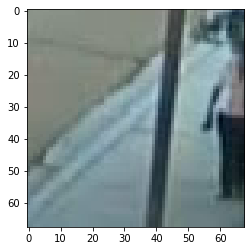

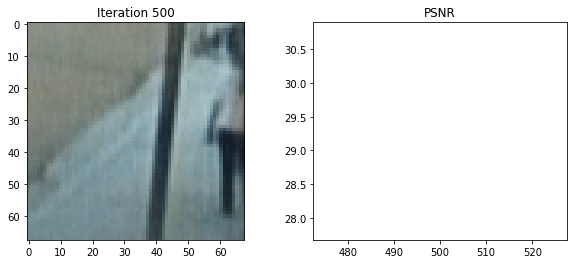

Start frame: 10, end frame: 20
Total frames: 10
Loss: 0.003541019046679139


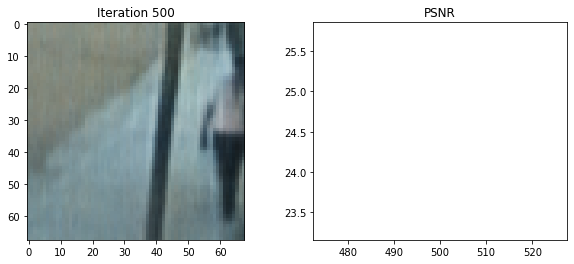

Start frame: 20, end frame: 30
Total frames: 10
Loss: 0.0016623848350718617


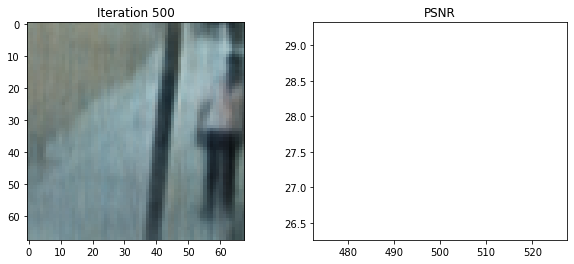

Start frame: 30, end frame: 40
Total frames: 10
Loss: 0.0025441600009799004


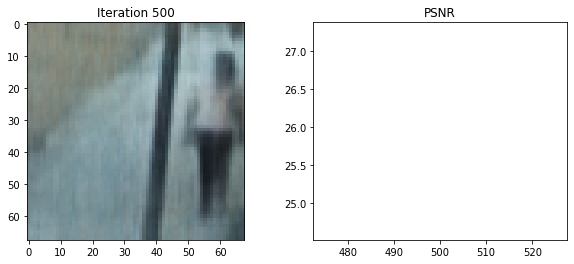

Start frame: 40, end frame: 50
Total frames: 10
Loss: 0.0019811925012618303


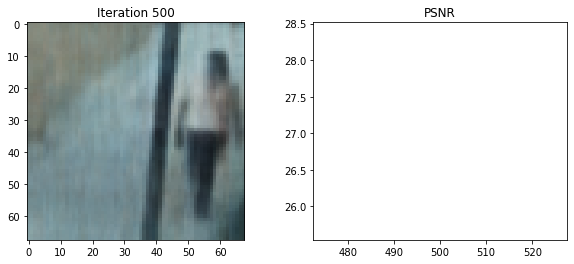

Start frame: 50, end frame: 60
Total frames: 10
Loss: 0.0021477602422237396


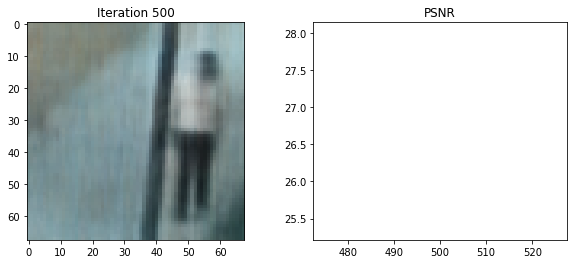

Start frame: 60, end frame: 70
Total frames: 10
Loss: 0.002235214225947857


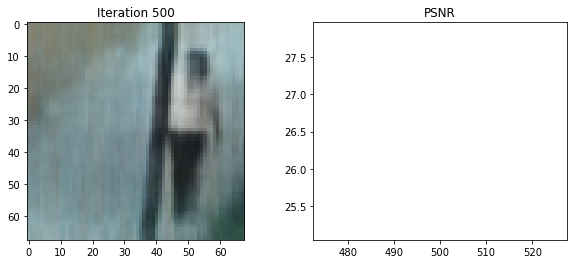

Start frame: 70, end frame: 80
Total frames: 10
Loss: 0.0020208058413118124


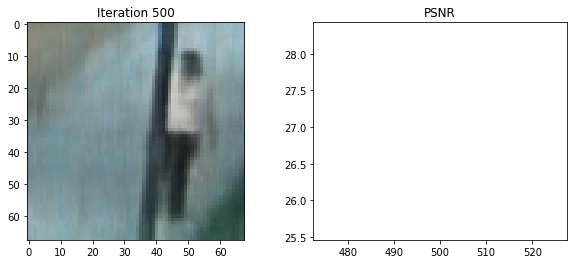

Start frame: 80, end frame: 90
Total frames: 10
Loss: 0.0018625750672072172


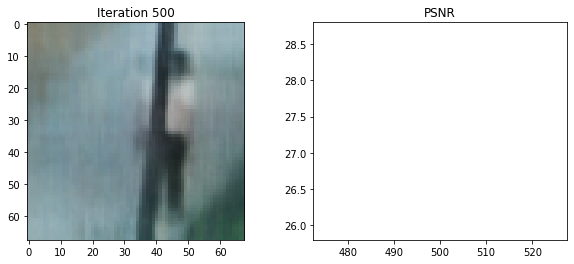

Start frame: 90, end frame: 100
Total frames: 10
Loss: 0.0021030139178037643


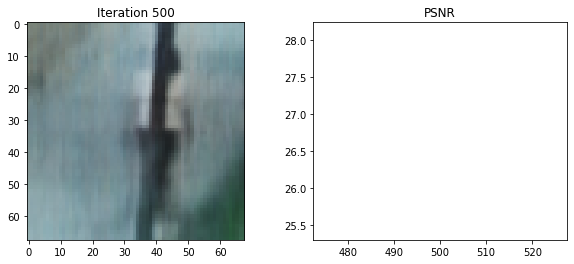

Start frame: 100, end frame: 110
Total frames: 10
Loss: 0.0041515720076859


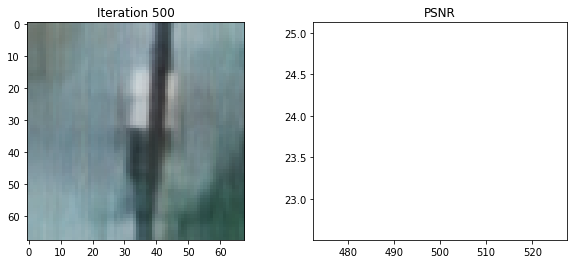

Start frame: 110, end frame: 120
Total frames: 10
Loss: 0.004991992376744747


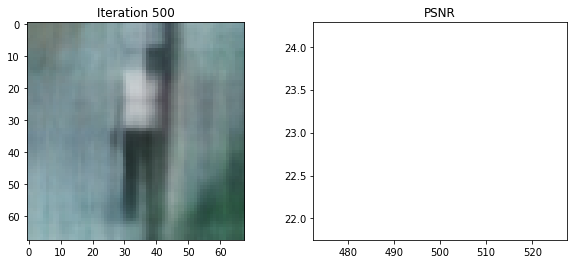

Start frame: 120, end frame: 130
Total frames: 10
Loss: 0.00326161808334291


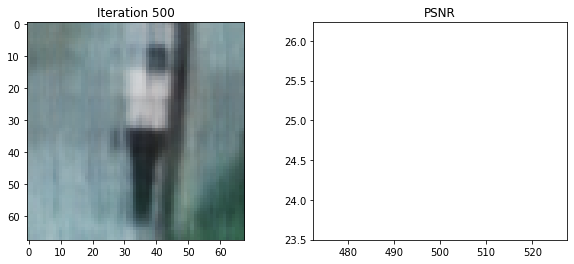

Start frame: 130, end frame: 140
Total frames: 10
Loss: 0.006009168457239866


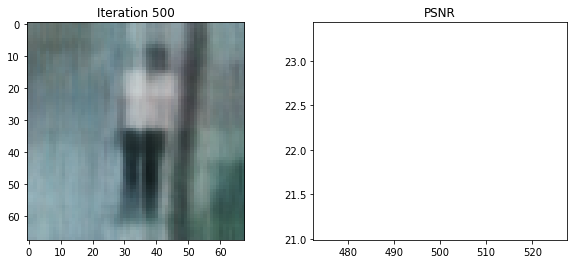

Done training. Storing output...
Output complete


In [24]:
"""
Parameters for NPC training
"""

num_hidden_layers = 4
filter_size = 256
# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 12

# Specify encoding function.


def encode(x): return positional_encoding(
    x, num_encoding_functions=num_encoding_functions, include_input=True, log_sampling=True)


# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
# Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.
chunksize = 16384 * 16

# Optimizer parameters
lr = 5e-3
num_iters = 500

# Misc parameters
display_every = 500  # Number of iters after which stats are displayed

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 1337
torch.manual_seed(seed)
np.random.seed(seed)



plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(get_frame(test_frame))

total_total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))


def output_video(fps, width: int, height: int, encode, get_minibatches, chunksize):
  r"""Build the final video from the trained model."""
  out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

  def output_v(total_frames, model):
    for f in range(total_frames):
        rgb_predicted = one_iter_npc(width, height, model,
                                    f, encode,
                                    get_minibatches, chunksize)

        rgb_out = cv2.normalize(src=rgb_predicted.detach().cpu().numpy(), dst=None, alpha=0, beta=255,
                norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        out.write(rgb_out)
    return lambda: out.release()
  
  return output_v

outputter = output_video(fps, width, height, encode, get_minibatches, chunksize)


print("Video dims: " + str(width) + "x" + str(height))
print("Framerate: " + str(fps))

release_out = None

def training_loop(start_frame, end_frame, outputter, chunksize):
  total_frames = end_frame - start_frame
  test_frame = start_frame

  print("Start frame: " + str(start_frame) + ", end frame: " + str(end_frame))
  print("Total frames: " + str(total_frames))

  model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions,
                            num_hidden_layers=num_hidden_layers, filter_size=filter_size)

  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  # Lists to log metrics etc.
  psnrs = []
  iternums = []

  for i in range(num_iters + 1):
    # Randomly pick a frame as the target
    target_frame_idx = np.random.randint(start_frame, end_frame)

    target_img = get_frame(target_frame_idx)
    
    rgb_predicted = one_iter_npc(width, height, model,
                                target_frame_idx, encode,
                                get_minibatches, chunksize)

    # Compute mean-squared error between the predicted and target images. Backprop!
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Display images/plots/stats
    if (i > 0) and (i % display_every == 0):
      # Render the held-out view
      rgb_predicted = one_iter_npc(width, height, model,
                                  test_frame, encode,
                                  get_minibatches, chunksize)

      loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
      print("Loss:", loss.item())
      psnr = -10. * torch.log10(loss)

      psnrs.append(psnr.item())
      iternums.append(i)

      plt.figure(figsize=(10, 4))
      plt.subplot(121)
      plt.imshow(rgb_predicted.detach().cpu().numpy())
      plt.title(f"Iteration {i}")
      plt.subplot(122)
      plt.plot(iternums, psnrs)
      plt.title("PSNR")
      plt.show()

  release_out = outputter(total_frames, model)
  return release_out



total_total_frames = 140

chunk_size = 10

for i in range (0, total_total_frames, chunk_size):
  release_out = training_loop(i, min(total_total_frames, i+chunk_size), outputter, chunksize)

print('Done training. Storing output...')
torch.save(model.state_dict(), "model.pt")
release_out()
print("Output complete")
